In [1]:
#load the libraries
import pandas as pd
import string
import re
import numpy as np
from collections import Counter
%load_ext rpy2.ipython
%R library(ggplot2)
%R library(scales)
%R library(statebins)

array(['statebins', 'scales', 'ggplot2', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [2]:
df = pd.read_csv('/Users/dillonquan/Desktop/ds_jobs/alldata.csv')

In [3]:
def categorize(s):
    """categorizes the job position to bins of SEAM (scientist, data engineer, analyst, ML)"""
    
    patterns = ['.*data sci.*','.*data.*eng.*', '.*analy.*', '.*machine.*']
    for idx, pattern in enumerate(patterns):
        reg = re.compile(pattern)
        if reg.search(s):
            return idx
    return -1

In [4]:
#for columns that are strings but with NaN, turn those NaN into str type nan
for col in df.columns:
    if (df[col].dtype == 'object'):
        df.loc[df[col].isna(), col] = 'nan'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6964 entries, 0 to 6963
Data columns (total 5 columns):
position       6964 non-null object
company        6964 non-null object
description    6964 non-null object
reviews        5326 non-null float64
location       6964 non-null object
dtypes: float64(1), object(4)
memory usage: 272.1+ KB


In [5]:
#removes the zip code or any other info to have only the city and state
no_zip = []
for place in df.location:
    place = place.strip()
    if place[-1] in string.digits:
        no_zip.append(place[:-5].strip())
    else:
        no_zip.append(place.strip())
df.location = pd.Series(no_zip)
df.head()

,position,company,description,reviews,location
0,Development Director,ALS TDI,Development Director\nALS Therapy Development ...,NaN,"Atlanta, GA"
1,An Ostentatiously-Excitable Principal Research...,The Hexagon Lavish,"Job Description\n\n""The road that leads to acc...",NaN,"Atlanta, GA"
2,Data Scientist,Xpert Staffing,"Growing company located in the Atlanta, GA are...",NaN,"Atlanta, GA"
3,Data Analyst,Operation HOPE,DEPARTMENT: Program OperationsPOSITION LOCATIO...,44.0,"Atlanta, GA"
4,Assistant Professor -TT - Signal Processing & ...,Emory University,DESCRIPTION\nThe Emory University Department o...,550.0,"Atlanta, GA"


In [6]:
#lowercase the job position
df['position'] = df['position'].apply(lambda x : x.lower())
df.head()

,position,company,description,reviews,location
0,development director,ALS TDI,Development Director\nALS Therapy Development ...,NaN,"Atlanta, GA"
1,an ostentatiously-excitable principal research...,The Hexagon Lavish,"Job Description\n\n""The road that leads to acc...",NaN,"Atlanta, GA"
2,data scientist,Xpert Staffing,"Growing company located in the Atlanta, GA are...",NaN,"Atlanta, GA"
3,data analyst,Operation HOPE,DEPARTMENT: Program OperationsPOSITION LOCATIO...,44.0,"Atlanta, GA"
4,assistant professor -tt - signal processing & ...,Emory University,DESCRIPTION\nThe Emory University Department o...,550.0,"Atlanta, GA"


In [7]:
#creating a new column to categorize job positions
df['label'] = -1
for idx, row in df.iterrows():
    cat = categorize(row.position)
    if cat != -1:
        df.loc[idx, 'label'] = cat

In [8]:
#return only SEAM positions
df_filter = df.loc[(df.label != -1),:]
df_a = df.loc[(df.label == 2),:]

In [9]:
#create a df that only has the state and the number of SEAM positions in that state
df_loc = df_filter.groupby('location', as_index=False).agg({'company':'count'})
df_loc['state'] = df_loc.location.str[-2:]
df_loc.sort_values('state', inplace=True)
state = df_loc[['state', 'company']].groupby('state').sum().reset_index()
state

,state,company
0,CA,1022
1,CO,26
2,DC,217
3,GA,141
4,IL,269
5,MA,426
6,NJ,40
7,NY,626
8,TX,97
9,WA,341


In [10]:
df_filter[['label', 'position']].groupby('label').count()

,position
label,
0,1444
1,218
2,1079
3,464


In [11]:
#include all the other states that we dont have information on
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA",
"HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
"MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
"NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
"SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

states = pd.DataFrame(states)
states.columns = ['states']
state = pd.merge(state, states, left_on = 'state', right_on ='states', how = 'right')
state = state.fillna(0)

In [12]:
state = state.drop('state', axis = 1).rename(columns={'states':'state'})
state['company'] = state['company'].astype(int)
state.loc[state.state.isin(['NJ', 'CO', 'TX']), 'company'] = 100
state['company'] = state['company']*-1
state.head()

,company,state
0,-1022,CA
1,-100,CO
2,-217,DC
3,-141,GA
4,-269,IL


## Statebin Graph

In [13]:
%R -i state

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



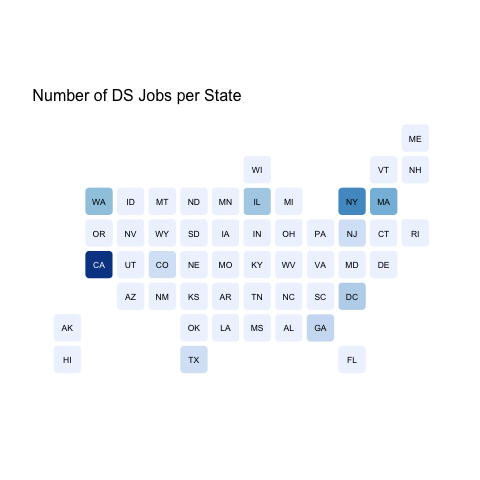

In [14]:
%%R

statebins(state, value_col = "company", round = TRUE) +
labs(title = 'Number of DS Jobs per State') +
scale_fill_distiller(palette = "Blues") +
theme_statebins(legend_position = "none")
#ggsave('statebins.png', width = 7, height = 5)

## Job category in dataset percentage Bar Graph

In [68]:
df_per = (df[['label', 'position']].groupby('label').count()/6964).reset_index()
title = ['Other', 'Data Scientist', 'Data Engineer', 'Data Analyst', 'ML Engineer']
for idx, _ in df_per.iterrows():
    df_per.loc[idx,'label'] = title[idx]

In [69]:
df_per.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
label       5 non-null object
position    5 non-null float64
dtypes: float64(1), object(1)
memory usage: 160.0+ bytes


In [70]:
df_per['flag'] = False
df_per.loc[0, 'flag'] = True

In [71]:
df_per = df_per.sort_values(by = 'position', ascending = False)
df_per.label = pd.Categorical(df_per.label, categories = df_per.label, ordered = True)

In [72]:
df_per

,label,position,flag
0,Other,0.539776,True
1,Data Scientist,0.207352,False
3,Data Analyst,0.154940,False
4,ML Engineer,0.066628,False
2,Data Engineer,0.031304,False


In [73]:
%R -i df_per

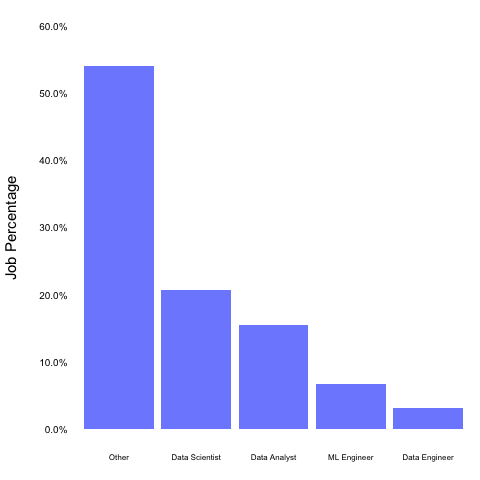

In [118]:
%%R

ggplot() + geom_bar(aes(x = label, y = position), data = df_per, stat = 'identity', fill = '#244AFC', alpha = .65) +
scale_y_continuous(limits = c(0, .6), breaks = seq(0,.6, by = .1), label = percent) +
xlab('') +
ylab('Job Percentage') +
theme(panel.background = element_blank(), axis.ticks = element_blank(), axis.text.x = element_text(size = 8, color = 'black'),
     axis.text.y = element_text(size = 10, color = 'black'),axis.title.y = element_text(size = 15, margin = margin(t = 0, r = 20, b = 0, l = 0)))

#ggsave('bar1.png', width = 7, height = 5)

In [89]:
df_per

,label,position,flag
0,Other,0.539776,True
1,Data Scientist,0.207352,False
3,Data Analyst,0.154940,False
4,ML Engineer,0.066628,False
2,Data Engineer,0.031304,False


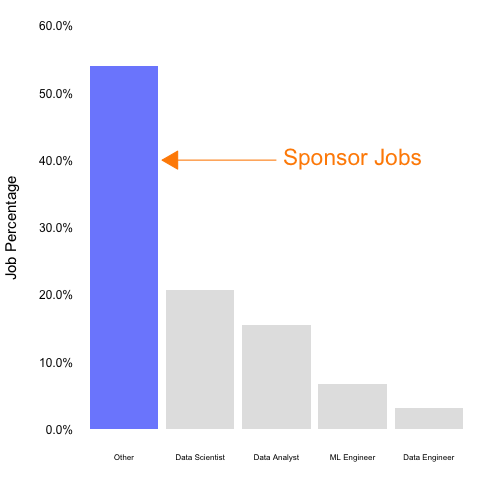

In [119]:
%%R

ggplot() + geom_bar(aes(x = label, y = position, fill = flag), data = df_per, stat = 'identity', alpha = .65) +
geom_segment(aes(x = 'Data Analyst',xend = 1.5, y = .4, yend = .4), arrow = arrow(type = 'closed'), colour = 'darkorange') +
annotate('text', x = 4, y = .405, label = 'Sponsor Jobs', colour = 'darkorange', size = 8) +
scale_fill_manual(values = c('lightgrey','#244AFC')) +
scale_y_continuous(limits = c(0, .6), breaks = seq(0,.6, by = .1), label = percent) +
xlab('') +
ylab('Job Percentage') +
theme(panel.background = element_blank(), axis.ticks = element_blank(), axis.text.x = element_text(size = 8, color = 'black'),
     axis.text.y = element_text(size = 12, color = 'black'), legend.position = 'none',
      axis.title.y = element_text(size = 15, margin = margin(t = 0, r = 20, b = 0, l = 0)))
#ggsave('bar2.png', width = 7, height = 5)